## LINE ANGLE CLASSIFIER V1 - Logical Regression

### Trained with 1000  random Lines, with variable lengths, positions and angles
 - 25 % Horizontal lines, coded as 0
 - 25 % Vertical lines, coded as 1
 - 25 % Ascending lines, coded as 2
 - 25 % Descending lines, coded as 3

In [2]:
import os
from scipy import misc
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate

# FOR LINEAR REGRESSION
from sklearn.linear_model import SGDRegressor

# FOR CLASSIFICATION 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import math
import scipy as sc
import pickle

%matplotlib inline



## Our data set

In [3]:
folder = 'IMAGES_1000_CLASSIFICATION'
noOfImages = 1000
dim =100 

## Utilities for feature extraction

In [4]:
def RotateImage(image, dim):
    
    new_image = np.zeros((dim, dim), dtype=np.uint8)
    new_image[:,:] = 255 
     
    # Rotate
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
            new_image[ dim - row -1,col] = image[row,  col] 

    # Copy back 
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
             image[row,  col] = new_image[row, col]

In [5]:
'''
For projecting the image on the y axis
'''
def Get_Y_Shadow(image):
    dim = 100  
    #y_shadow =  np.zeros(dim, dtype=np.uint8) 
    y_shadow =  np.full(dim,  255) 
    index= 0
    
    # Start from left col (x=0) to last col (x= 99
    for col in range(0,100): # Visit all collumns
        for row in range(0,100): 
            gray = image[row,  col]
            if  gray == 0 : # Look for non-white pixels
                # Project on y-axis
                if y_shadow[row]== 255: # Move if not was already plotted
                    index = index + 1  
                # Project on y-axis
                y_shadow[row]= col # y_shadow[row] + 1 
                 
     
    #print(index)
    # ADJUSTED index needs to be less one
    index = index -1
    
    return y_shadow,index
                    

In [6]:
'''
For projecting the image on the x axis
'''
def Get_X_Shadow(image):
    dim = 100  
    #x_shadow =  np.zeros(dim, dtype=np.uint8) 
    x_shadow =  np.full(dim,  255) 
        
    index= 0
    
    # Start from top row (y=99) to last row (y= 99
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
            gray = image[row,  col]
            if  gray == 0 : # Look for non-white pixels
                
                if x_shadow[col]== 255: # Move if not was already plotted
                    index = index + 1  
                # Project on y-axis
                x_shadow[col]= dim - 1- row #x_shadow[col] + 1 
     
    #print(index)
    
    # ADJUSTED index needs to be less one
    index = index -1
    
    return x_shadow,index
                    

In [7]:
def getFirstFromLeft(a, dim):
    for i in range(0,dim):
        if   a[i] != 255 :
            #print('From left: {}:{}'.format( i,a[i] ))
            return a[i]  

In [8]:
def getFirstFromRight(a, dim):
    for i in range(dim-1,-1,-1):
        #print(i)
        if   a[i] != 255 :
            #print('From right: {}:{}'.format( i,a[i] ))
            return a[i]  

In [9]:
def CheckIfDescends ( a, dim):
    left = getFirstFromLeft(a, dim)   
    right = getFirstFromRight(a, dim)
    
    return right < left

In [10]:
def Count(image, gray, dim): 
    c = 0
    for row in range(0,100): 
        for col in range(0,100):  
            if image[row,  col] == gray :  
                c= c+ 1 
    return c
                    

In [11]:
'''
For reducing the features, we condense the columns into one column
and the rows in one row. We will reduce and work with two features
    - yShadow
    - xShadow
'''
def ExtractImageFeatures( image, dim):
    
    # Safety check - do now work with empty images!
    # if data may have empty images enables this
    # c= Count(image, 0, 100)
    # if c== 0:
    #    print ("***EMPTY IMAGE FOUND!!!!") 
    #    return 0,0
     
 
    yShadow,dy = Get_Y_Shadow(image) 
    xShadow,dx = Get_X_Shadow(image)
 
    lineDescends = CheckIfDescends(xShadow,dim)
    if lineDescends:
        dy = -1*dy
        
    return dx,dy
    

## Create an array to store yShadow and xShadow

In [12]:
print(dim)
print(noOfImages)
print(folder)

x_data = np.zeros((noOfImages, 2))

#x_data = np.zeros((noOfImages, dim*2))
print( x_data.shape)

100
1000
IMAGES_1000_CLASSIFICATION
(1000, 2)


## Read x_data, all images in an array

In [13]:
'''
For loop that reads and processes all the images into a X
'''  

for count in range(0,noOfImages ):
           
    filename = "./DATA/" + str(folder) + "/"+ "im_" +str(count) + ".bmp" 
    
    image= misc.imread(filename, flatten= 1)   
     
    # Later need to try to use the shadows themself directly!
    dx,dy = ExtractImageFeatures( image, dim)
    
    # Using dx and dy extracted from image
    x_data[count,0]= dx
    x_data[count,1]= dy
   
    

C:\Users\admin\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


In [14]:
x_data.shape

(1000, 2)

## Read y_data

In [15]:

filename = "./DATA/" + str(folder) + "/"+ "ydata.csv"  
   
#yDataFrame.to_csv(filename, index =False)
#yDataFrame.to_csv?

# Read data frame
yDF= pd.read_csv(filename)
yDF.head(10)

yAngle = pd.DataFrame( yDF.loc[:,'angle'])

#yAngle.head(10)

yLength =  pd.DataFrame( yDF.loc[:,'length'])
 
x1_DF =  pd.DataFrame( yDF.loc[:,'x1'])
y1_DF =  pd.DataFrame( yDF.loc[:,'y1'])
x2_DF =  pd.DataFrame( yDF.loc[:,'x2'])
y2_DF =  pd.DataFrame( yDF.loc[:,'y2'])

yAngleLabel= pd.DataFrame( yDF.loc[:,'angle_label'])
yAngleCode = pd.DataFrame( yDF.loc[:,'angle_code'])


print("Mean=>{}".format( yAngle.mean() ))
print("Mean=>{}".format( yLength.mean()))

print("Mean=>{}".format( x1_DF.mean() ))
print("Mean=>{}".format( y1_DF.mean()))

print("Mean=>{}".format( x2_DF.mean() ))
print("Mean=>{}".format( y2_DF.mean()))

#print(yDF)


Mean=>angle    22.721627
dtype: float64
Mean=>length    38.99061
dtype: float64
Mean=>x1    43.388
dtype: float64
Mean=>y1    46.322
dtype: float64
Mean=>x2    65.347
dtype: float64
Mean=>y2    54.106
dtype: float64


In [16]:
#Our Target
yAngleCode.head(10)

,angle_code
0,0.0
1,1.0
2,2.0
3,3.0
4,0.0
5,1.0
6,2.0
7,3.0
8,0.0
9,1.0


In [17]:
X= x_data
y= yAngleCode
print (x_data.shape)
print(y.shape)

(1000, 2)
(1000, 1)


## PCA with one component - AngleCode

In [18]:
pca = PCA(n_components=1)

Z = pca.fit_transform(X) # Z is 2-D
print(Z.shape)
print(y.shape)

(1000, 1)
(1000, 1)


[Text(0, 0.5, 'Angle Code: 0=HOR; 1=VER, 2=ASC 3=DESC'),
 Text(0.5, 0, 'f1'),
 Text(0.5, 1.0, 'PCA of data vs angle_code')]

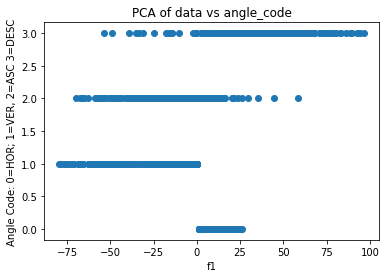

In [19]:
fig, ax = plt.subplots()
ax.scatter(Z,y)

ax.set( title = 'PCA of data vs angle_code',
      xlabel = 'f1',
      ylabel= 'Angle Code: 0=HOR; 1=VER, 2=ASC 3=DESC')

## TRAINING

In [20]:
X= x_data
y= yAngleCode

# We need to ravel y,  e.g make (1000,)
yNp = yAngleCode.values
yNp = yNp.ravel()
print(type (yNp))
y =    yNp 
y.shape

<class 'numpy.ndarray'>


(1000,)

In [21]:
print(X.shape)
print(y.shape)

(1000, 2)
(1000,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(750, 2) (250, 2) (750,) (250,)


In [23]:
# Must be flatten how?
print( y_train.shape )
print(y_test.shape )


print( type (y_train ))


(750,)
(250,)
<class 'numpy.ndarray'>


In [24]:
# scale X_train to normalise the feature ranges
X_scaler = StandardScaler()
Z_train = X_scaler.fit_transform(X_train)

In [25]:
# Linear Regression using Gradient Descent

sgd_classifier_model = SGDClassifier(max_iter=1000, 
                     tol=1e-3,
                     random_state=8)

 
scores = cross_validate(sgd_classifier_model, Z_train, y_train, cv=5,
                        return_train_score=True,
                        return_estimator=True) # models
scores

{'fit_time': array([0.01199079, 0.01198077, 0.00399661, 0.00798941, 0.00799084]),
 'score_time': array([0.       , 0.       , 0.       , 0.0039947, 0.       ]),
 'estimator': (SGDClassifier(alpha=0.0001, average=False, class_weight=None,
         early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
         l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
         n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
         power_t=0.5, random_state=8, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start=False),
  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
         early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
         l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
         n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
         power_t=0.5, random_state=8, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start=False),
  

### Learning Curve

In [26]:
train_sizes, train_scores, val_scores = learning_curve(sgd_classifier_model, 
                                                       Z_train,
                                                       y_train,
                                                       cv=3)

In [27]:
# accuracy scores on val show a slight overfitting

print( val_scores.mean(axis=1) )
print()

[0.5237598  0.67989333 0.68941439 0.703621   0.66262905]



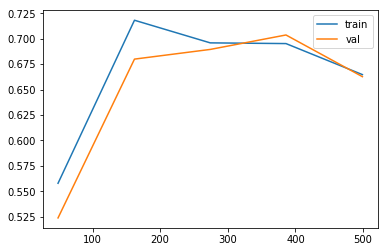

In [28]:
# plot average (over 3-folds) train_scores vs. train_sizes
# plot average (over 3-folds) val_scores vs. train_sizes

fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores.mean(axis=1), label='train')
ax.plot(train_sizes, val_scores.mean(axis=1), label='val')
ax.legend()

### Choose best model

In [29]:
print('validation scores (sgd)' ,scores['test_score'])

validation scores (sgd) [0.71523179 0.63333333 0.81333333 0.83333333 0.71812081]


In [30]:
# Based on validation best model is at index 3

sgd_classifier_best_model = scores['estimator'][3] 

### Get predictions on X_test => y_pred


In [31]:
Z_test = X_scaler.transform(X_test)
y_pred = sgd_classifier_best_model.predict(Z_test)



In [32]:
print(y_pred.shape)
print(y_test.shape)

(250,)
(250,)


In [33]:
print( type(y_test ))
print( type(y_pred ))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [34]:
# For inspection turn y_test and y_pred into DataFrame
y_test_DF = pd.DataFrame(y_test)
y_pred_DF = pd.DataFrame(y_pred)
print(y_test_DF.head(10) )
print()
print(y_pred_DF.head(10) )

     0
0  2.0
1  2.0
2  3.0
3  2.0
4  0.0
5  0.0
6  0.0
7  2.0
8  3.0
9  2.0

     0
0  2.0
1  2.0
2  3.0
3  2.0
4  0.0
5  0.0
6  0.0
7  2.0
8  3.0
9  2.0


In [35]:
print( classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.65      0.75        55
         1.0       0.95      1.00      0.97        71
         2.0       0.96      0.83      0.89        65
         3.0       0.69      0.92      0.79        59

   micro avg       0.86      0.86      0.86       250
   macro avg       0.87      0.85      0.85       250
weighted avg       0.88      0.86      0.86       250



## Saving the model

In [36]:
# save model and scaler for later use
pickle.dump(X_scaler, open('angle_classifier_X_scaler.pickle', 'wb'))
pickle.dump(sgd_classifier_best_model, open('angle_classifier.pickle', 'wb'))




## Prediction on a given image

In [37]:
import math
import scipy as sc

def LoadScalerModel():
    X_scaler = pickle.load(open('angle_classifier_X_scaler.pickle', 'rb'))
    model = pickle.load(open('angle_classifier.pickle', 'rb'))
    
    return X_scaler, model



###  For user

In [38]:
def PredictAngleClassOfLine():
    # We work with one image ( we extract two features)
    noOfImages =1
    dim = 100
    df_X = np.zeros((noOfImages, 2))

    # Load X_scaler and Model
    X_scaler, model = LoadScalerModel()
    
    # Extract image features


    dx,dy = ExtractImageFeatures( image, dim)
 

    # Store the extracted features 
    df_X[0,0]= dx
    df_X[0,1]= dy
 
    # let's see the first model
    df_Z = X_scaler.transform(df_X)  
                                    
    print("dx= {}, dy= {}".format(dx,dy))  
    
    y_pred = model.predict(df_Z )
    
    angle_class_predict = y_pred[0]
    
    return angle_class_predict

    

In [39]:
def ConvertClassCodeToLabel(code):
    if code == 0.0:
        return 'HORIZONTAL'
    if code == 1.0:
        return 'VERTICAL'
    if code == 2.0:
        return 'ASCENDING'
    if code == 3.0:
        return 'DESCENDING'
    

## MAIN PREDICT

### Input your image

C:\Users\admin\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


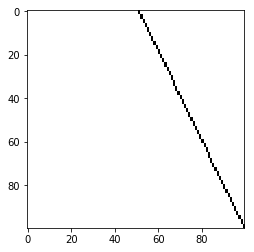

In [40]:
# Load image and display
image= sc.misc.imread("./TEST/test6.bmp", flatten= 1)
plt.imshow(image, cmap='gray') 

### Run the prediction

In [42]:
# Model is precise for ascending slopes, 
# but not for descending slopes

class_code= PredictAngleClassOfLine()
#print('Angle predicted= {}'.format(a))
 
    
print('Angle Class Code predicted= {}'.format(class_code))

print('Line Angle Class predicted = {}'.format(ConvertClassCodeToLabel(class_code)))

dx= 48, dy= -99
Angle Class Code predicted= 3.0
Line Angle Class predicted = DESCENDING
